## Convolutional Neural Network Models

Convoluational neural networks (CNNs) have long been the foundation of computer vision. Although surpassed by transformer-based models in large-scale and data-rich settings, they remain competitibe for efficiency and resource-constrained applications. We implemented several CNN models, which include AlexNet, VGG-16, ResNet-18, and ResNet-34. We then compared the performance of different architectures.

### Model Implementation

In [1]:
import torch.nn as nn
model_args = {
    'in_channels': 1,
    'num_classes': 15
}

''' Get the number of parameters of a model '''
def get_num_params(model: nn.Module):
  return sum(p.numel() for p in model.parameters())

#### 1. AlexNet

AlexNet consists of five convolutional layers followed by three fully connected layers, using large receptive fields, ReLU activations, overlapping max-pooling, and dropout to improve training efficiency and reduce overfitting.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AlexNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

num_params = get_num_params(AlexNet(**model_args))
print(f"Number of parameters in AlexNet: {num_params}({num_params:.2e})")

Number of parameters in AlexNet: 57049807(5.70e+07)


#### 2. VGG

VGG adopts a simple and uniform architecture that stacks multiple small 3×3 convolutional layers with ReLU interleaved with max-pooling layers, followed by three fully connected layers for classification, emphasizing depth and simplicity over large convolutional kernels. VGG has different variants, such as VGG-11, VGG-13, VGG-16, and VGG-19, which differ in the number of convolutional layers stacked within each block. This offers a trade-off between model depth and computational cost, while maintaing a uniform overall architecture. We leveraged this characteristic to efficiently implement different VGG variants with one unified class.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from enum import Enum


class VGG(nn.Module):

    class Variant(Enum):
        VGG11 = '11'
        VGG13 = '13'
        VGG16 = '16'
        VGG19 = '19'

    _architectures = {
        Variant.VGG11: [
            64, 'M',
            128, 'M',
            256, 256, 'M',
            512, 512, 'M',
            512, 512, 'M'
        ],
        Variant.VGG13: [
            64, 64, 'M',
            128, 128, 'M',
            256, 256, 'M',
            512, 512, 'M',
            512, 512, 'M'
        ],
        Variant.VGG16: [
            64, 64, 'M',
            128, 128, 'M',
            256, 256, 256, 'M',
            512, 512, 512, 'M',
            512, 512, 512, 'M'
        ],
        Variant.VGG19: [
            64, 64, 'M',
            128, 128, 'M',
            256, 256, 256, 256, 'M',
            512, 512, 512, 512, 'M',
            512, 512, 512, 512, 'M'
        ]
    }

    def __init__(self, in_channels, num_classes, variant='16'):
        super(VGG, self).__init__()
        if not isinstance(variant, self.Variant):
            variant = self.Variant(variant)
        self.conv_layers = self._make_conv_layers(
            in_channels,
            self._architectures[variant]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        self._init_weights()

    def _make_conv_layers(self, in_channels, arch):
        layers = []
        channels = in_channels
        for x in arch:
            if type(x) == int:
                layers.append(nn.Conv2d(channels, x, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                channels = x
            elif x == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                raise ValueError(f"VGG unknown layer: {x}")
        layers.append(nn.AdaptiveAvgPool2d((7, 7)))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

for variant in ['11', '13', '16', '19']:
    num_params = get_num_params(VGG(**model_args, variant=variant))
    print(f"Number of parameters in VGG-{variant}: {num_params}({num_params:.2e})")

Number of parameters in VGG-11: 128826639(1.29e+08)
Number of parameters in VGG-13: 129011151(1.29e+08)
Number of parameters in VGG-16: 134320847(1.34e+08)
Number of parameters in VGG-19: 139630543(1.40e+08)


#### 3. ResNet

ResNet introduces residual connections to mitigate the vanishing gradient problem, enabling training very deep networks effectively. Similar to VGG, it is structured with stacks of residual blocks, with popular variants like ResNet-18, ResNet-35, ResNet-50, ResNet-101 ,and ResNet-152, differing both in depth and block structure. We implemented ResNet-18 and ResNet-34 as examples.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from enum import Enum


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    class Variant(Enum):
        RESNET18 = '18'
        RESNET34 = '34'

    _architectures = {
        Variant.RESNET18: (BasicBlock, [2, 2, 2, 2]),
        Variant.RESNET34: (BasicBlock, [3, 4, 6, 3])
    }

    def __init__(self, in_channels, num_classes, variant='18'):
        super(ResNet, self).__init__()
        if not isinstance(variant, self.Variant):
            variant = self.Variant(variant)
        block, layers = self._architectures[variant]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        self._init_weights()

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

for variant in ['18', '34']:
    num_params = get_num_params(ResNet(**model_args, variant=variant))
    print(f"Number of parameters in VGG-{variant}: {num_params}({num_params:.2e})")

Number of parameters in VGG-18: 11177935(1.12e+07)
Number of parameters in VGG-34: 21286095(2.13e+07)


### Experimental Evaluation

We conducted experiments to evaluate and comapre the models using the metrics discussed earlier. Also, we applied the management schemes discussed in the previous section during training.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os


def show_model_comparison(metric, methods, model_results, save_path=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    model_nb = len(model_results)
    cluster_width = 0.7
    width = cluster_width / model_nb

    xticks = np.arange(1, len(methods) + 1)

    title = f'Metric: {metric}'
    print(title)
    print('-' * len(title))

    for i, (model, results) in enumerate(model_results.items()):
        ax.bar(xticks - (width * model_nb / 2) +
               (width / 2) + width * i, results, width, label=model)
        print(f'[{model}]\t', end='')
        for m, v in zip(methods, results):
            print(f' \t{m}: {v:.2f}', end='')
        print()

    ax.set_xticks(xticks)
    ax.set_xticklabels(methods)
    ax.set_xlabel('Sampling Method')
    ax.set_ylabel(metric)
    ax.legend()

    if save_path != None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)

    plt.show()

Metric: Predicttion Accuracy (%)
--------------------------------
[AlexNet]	 	Original: 68.70 	Round-Robin: 92.40 	Rare-First: 100.00
[ResNet-18]	 	Original: 66.47 	Round-Robin: 92.88 	Rare-First: 100.00
[ResNet-34]	 	Original: 68.02 	Round-Robin: 92.80 	Rare-First: 100.00
[VGG-16]	 	Original: 67.31 	Round-Robin: 92.84 	Rare-First: 100.00


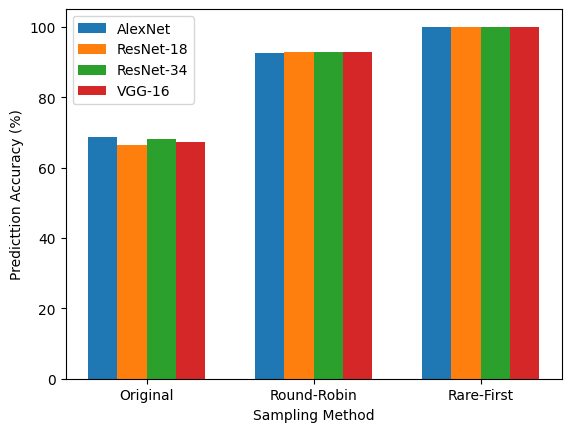

In [6]:
metric = 'Predicttion Accuracy (%)' 
methods = ['Original', 'Round-Robin', 'Rare-First']
model_results = {
    'AlexNet': [68.70, 92.40, 100.00],
    'ResNet-18': [66.47, 92.88, 100.00],
    'ResNet-34': [68.02, 92.80, 100.00],
    'VGG-16': [67.31, 92.84, 100.00]
}

show_model_comparison(metric, methods, model_results)

Metric: Disease Recall (%)
--------------------------
[AlexNet]	 	Original: 57.38 	Round-robin: 98.97 	Rare-first: 100.00
[ResNet-18]	 	Original: 65.23 	Round-robin: 100.00 	Rare-first: 100.00
[ResNet-34]	 	Original: 65.32 	Round-robin: 99.91 	Rare-first: 100.00
[VGG-16]	 	Original: 61.78 	Round-robin: 100.00 	Rare-first: 100.00


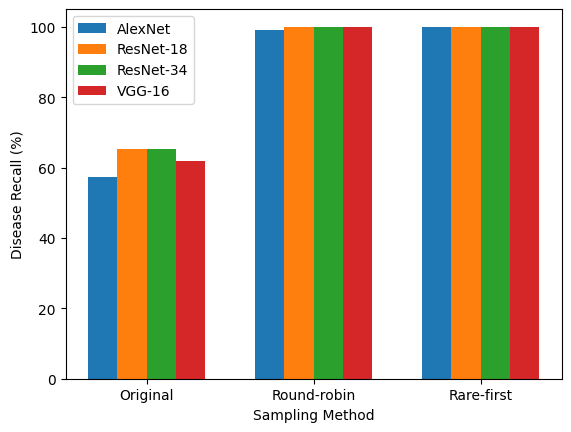

In [7]:
metric = 'Disease Recall (%)'
methods = ['Original', 'Round-robin', 'Rare-first']
model_results = {
    'AlexNet': [57.38, 98.97, 100.00],
    'ResNet-18': [65.23, 100.00, 100.00],
    'ResNet-34': [65.32, 99.91, 100.00],
    'VGG-16': [61.78, 100.00, 100.00]
}

show_model_comparison(metric, methods, model_results)

The figures show the performance of different models using different sampling methods.

First of all, we observe that rare-first sampling and round-robin sampling consistently help all models improve their predict accuracy and recall rate, demonstrating the effectiveness of our preprocessing for the unbalanced data. In the context of medical diagnosis, this improvement in accuracy and recall rate can be critical for practical application.

Training time per epoch on NVIDIA H100:

|      Model            | Training Time (s/epoch) |
| :---------------:     | :---------------------: |
|     AlexNet           |     3.7                 |
|     ResNet-18         |     6.1                 |
|     ResNet-34         |     9.0                 |
|     VGG-16            |     21.0                |

When comparing different models, similar performance is observed. Especiallly, the number of parameters in VGG-16 is much greater than other models, resulting in significantly longer training time. However, it doesn't show the best performance. In contrast, AlexNet can provide comparable performence with a relatively short training time. This result indicates that more parameters do not necessarily result in a better performance. When designing a deep learning system, we need to choose the architecture or model based on the scale and quality of the dataset and specific application scenarios.

Minimum training loss and validation loss at early stopping (round-robin sampling):

|      Model        | Traning Loss    | Validation Loss  |
| :---------------: | :-------------: | :--------------: |
|     AlexNet       |     0.177       |      0.313       |
|     ResNet-18     |     0.042       |      0.396       |
|     ResNet-34     |     0.038       |      0.431       |
|     VGG-16        |     0.038       |      0.729       |

The above table shows the traning loss and validation loss of differnt models when the training early stopped. With a larger number of parameters, VGG-16 has better learning ability than other models, which results in a smallest training loss. However, with limited training data, this also leads to a more obvious trend of overfitting, yielding a highest observed validation loss. This again validates our previous argument that it may not always be beneficial to have more parameters.

## Transformers Models

### Pretrained ViT

We encapsulated the ViT model from the `transformers` package to adapt it to our available pipeline. The model was fine-tuned using our preprocessed dataset after loading the pre-trained weights from Hugging Face.

In [8]:
import torch
import torch.nn as nn
from transformers import ViTConfig, ViTImageProcessor, ViTForImageClassification


class ViT_PT(nn.Module):

    def __init__(self, in_channels, num_classes, base_model_name="google/vit-base-patch16-224"):
        super().__init__()
        config = ViTConfig.from_pretrained(base_model_name)
        config.num_channels = in_channels
        config.num_labels = num_classes
        config.ignore_mismatched_sizes = True
        self.config = config
        self.tokenizer = ViTImageProcessor.from_pretrained(
            base_model_name, do_resize=False, do_rescale=True, do_normalize=False)
        self.base_model = ViTForImageClassification(config)

    def forward(self, x):
        assert x.shape[2] == self.config.image_size and x.shape[3] == self.config.image_size
        # x: [bs, in_channels, img_size, img_size]
        # Resize
        inputs = self.tokenizer.preprocess(images=x, data_format="channels_first",
                                           input_data_format="channels_first", return_tensors='pt')
        d = x.get_device()
        if d != -1:
            inputs = inputs.to(d)

        outputs = self.base_model(**inputs)
        return outputs.logits

The results for the fine-tuned ViT are shown in the following table shows the results for the ViT model after fine-tuning:

| Sampling Strategy | Predict Acc (%) | Predict Recall (%) |
| :---------------: | :-------------: | :----------------: |
|     Original      |     65.31%      |       57.20%       |
|    Round-robin    |     93.88%      |      100.00%       |
|    Rare-first     |     100.00%     |      100.00%       |